# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [6]:
import warnings

warnings.filterwarnings("ignore")

In [7]:
%matplotlib inline

from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
import statsmodels.api as sm
import talib
import yfinance as yf
from sklearn.preprocessing import scale
from statsmodels.regression.rolling import RollingOLS

In [8]:
sns.set_style("whitegrid")
idx = pd.IndexSlice

## Get Data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

# Otros Settings iniciales

In [9]:
normaliza = True  # normalizamos por volatilidad
neutraliza = False  # normalizado cross sectional media y vola

In [ ]:
DATA_STORE = "../data/assets.h5"

In [11]:
START = 1990
END = 2025


# Carga el dataframe desde el archivo csv
df = pd.read_csv('C:/Users/Inma/Documents/mis notebooks/Machine-Learning-for-Algorithmic-Trading-Second-Edition-master/data/tickers_darwinex.csv')

columna = df.columns[0]

# Añade '.US' al final de cada valor en la columna
df[columna] = df[columna].apply(lambda x: x + '.US')

# Almacena los valores de la primera columna en una lista. Los tickers
lista = df.iloc[:, 0].tolist()



# Cargamos los sectores y otra info
df_sect = pd.read_csv('C:/Users/Inma/Documents/mis notebooks/Machine-Learning-for-Algorithmic-Trading-Second-Edition-master/data/us_equities_meta_data.csv')


In [12]:
# etfs a considerar
princi = [
    "XLE.US",
    "XLB.US",
    "XLI.US",
    "XLK.US",
    "XLF.US",
    "XLP.US",
    "XLY.US",
    "XLV.US",
    "XLU.US",
    "IYR.US",
    "VOX.US",
    "SPY.US",
]
# princi=lista

In [13]:
"""ticker_list = ['XLE', 'XLB', 'XLI', 'XLK', 'XLF', 
               'XLP', 'XLY', 'XLV', 'XLU', 'IYR', 'VOX', 'SPY']"""
ticker_list = ["XLE", "XLB", "XLI", "XLK", "XLF", "XLP", "XLY", "XLV", "XLU", "SPY"]

# Here we use yf.download function
data = yf.download(
    # passes the ticker
    tickers=ticker_list,
    # used for access data[ticker]
    group_by="ticker",
)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


In [14]:
# apilamos tickers
data = data.stack(-2)
data

Price                    Open        High         Low       Close      Volume
Date       Ticker                                                            
1993-01-29 SPY      24.469899   24.469899   24.348158   24.452507   1003200.0
1993-02-01 SPY      24.469914   24.626438   24.469914   24.626438    480500.0
1993-02-02 SPY      24.609047   24.696005   24.556873   24.678614    201300.0
1993-02-03 SPY      24.713388   24.956869   24.695996   24.939478    529400.0
1993-02-04 SPY      25.026443   25.096009   24.748178   25.043835    531500.0
...                       ...         ...         ...         ...         ...
2025-05-16 XLK     235.210007  235.210007  232.860001  234.889999   4048900.0
           XLP      81.220001   82.070000   81.099998   82.070000  11972600.0
           XLU      81.110001   82.209999   80.910004   82.180000  10038400.0
           XLV     130.699997  133.139999  130.309998  133.089996  12895800.0
           XLY     216.360001  217.820007  215.779999  217.669998   2985200.0

[67900 rows x 5 columns]

In [15]:
data = data.swaplevel(0, 1)

In [16]:
data = data.rename_axis(["ticker", "date"])

In [17]:
# Reordenar y renombrar las columnas directamente
new_order = ["Open", "High", "Low", "Close", "Volume"]
new_names = ["open", "high", "low", "close", "volume"]

# Reordenar las columnas
prices = data[new_order]

# Renombrar las columnas
prices.columns = new_names

In [18]:
prices = prices.sort_index()

In [19]:
# Crear un nuevo DataFrame sin entradas duplicadas en el índice
prices = prices.loc[~prices.index.duplicated(keep="first")]

In [20]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 67900 entries, ('SPY', Timestamp('1993-01-29 00:00:00')) to ('XLY', Timestamp('2025-05-16 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    67900 non-null  float64
 1   high    67900 non-null  float64
 2   low     67900 non-null  float64
 3   close   67900 non-null  float64
 4   volume  67900 non-null  float64
dtypes: float64(5)
memory usage: 3.1+ MB


In [21]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 67900 entries, ('SPY', Timestamp('1993-01-29 00:00:00')) to ('XLY', Timestamp('2025-05-16 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    67900 non-null  float64
 1   high    67900 non-null  float64
 2   low     67900 non-null  float64
 3   close   67900 non-null  float64
 4   volume  67900 non-null  float64
dtypes: float64(5)
memory usage: 3.1+ MB


## Select 500 most-traded stocks

In [22]:
# si queremos selecionar los 500 o no
# selec_500= True
selec_500 = False

In [23]:
if selec_500 == True:
    dv = prices.close.mul(prices.volume)
    top500 = (
        dv.groupby(level="date")
        .rank(ascending=False)
        .unstack("ticker")
        .dropna(thresh=8 * 52, axis=1)
        .mean()
        .nsmallest(500)
    )
    to_drop = prices.index.unique("ticker").difference(top500.index)
    len(to_drop)
    prices = prices.drop(to_drop, level="ticker")

In [24]:
print(prices.index.unique("ticker"))

Index(['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY'], dtype='object', name='ticker')


In [25]:
# Suponiendo que 'df' es tu DataFrame
num_ticker = prices.index.get_level_values("ticker").nunique()

print(f'El índice "ticker" tiene {num_ticker} elementos únicos.')

El índice "ticker" tiene 10 elementos únicos.


In [26]:
prices.head()

open       high        low      close     volume
ticker date                                                             
SPY    1993-01-29  24.469899  24.469899  24.348158  24.452507  1003200.0
       1993-02-01  24.469914  24.626438  24.469914  24.626438   480500.0
       1993-02-02  24.609047  24.696005  24.556873  24.678614   201300.0
       1993-02-03  24.713388  24.956869  24.695996  24.939478   529400.0
       1993-02-04  25.026443  25.096009  24.748178  25.043835   531500.0

## eliminamos spy

In [27]:
prices.index

MultiIndex([('SPY', '1993-01-29'),
            ('SPY', '1993-02-01'),
            ('SPY', '1993-02-02'),
            ('SPY', '1993-02-03'),
            ('SPY', '1993-02-04'),
            ('SPY', '1993-02-05'),
            ('SPY', '1993-02-08'),
            ('SPY', '1993-02-09'),
            ('SPY', '1993-02-10'),
            ('SPY', '1993-02-11'),
            ...
            ('XLY', '2025-05-05'),
            ('XLY', '2025-05-06'),
            ('XLY', '2025-05-07'),
            ('XLY', '2025-05-08'),
            ('XLY', '2025-05-09'),
            ('XLY', '2025-05-12'),
            ('XLY', '2025-05-13'),
            ('XLY', '2025-05-14'),
            ('XLY', '2025-05-15'),
            ('XLY', '2025-05-16')],
           names=['ticker', 'date'], length=67900)

In [28]:
# eliminamos spy
prices = prices.drop(index="SPY", level=0)

In [29]:
prices = prices.sort_index(
    level=list(range(len(prices.index.names)))
)  # Sort all levels

In [30]:
# guardamos los datos de ohlcv
with pd.HDFStore(DATA_STORE) as store:
    store.put("data_close", prices.sort_index())
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/assets2.h5
/data_close            frame        (shape->[59769,5])


In [31]:
# hacemos unstack de close sólo
prices = prices.loc[idx[:, str(START) : str(END)], "close"].unstack("ticker")

In [32]:
prices

ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,
1998-12-22,11.660130,11.841597,11.335837,14.626595,23.982885,14.372802,11.996545,17.089304,18.907152
1998-12-23,11.782587,12.088137,11.502993,14.881837,24.555868,14.720261,11.946265,17.473330,18.988344
1998-12-24,12.053757,12.024511,11.578963,15.078162,24.462305,14.694834,12.166213,17.580002,19.336319
1998-12-28,11.948784,11.960890,11.427011,15.156692,24.532482,14.610083,12.103368,17.323996,19.162319
1998-12-29,12.167471,12.080184,11.548577,15.372652,24.602621,14.932117,12.304466,17.708017,19.579914
...,...,...,...,...,...,...,...,...,...
2025-05-12,86.519997,84.580002,50.869999,140.300003,227.699997,81.029999,79.760002,135.960007,212.470001
2025-05-13,86.089996,85.769997,51.080002,141.279999,232.619995,79.940002,79.650002,131.869995,215.279999
2025-05-14,85.300003,85.250000,50.939999,140.600006,234.130005,79.510002,79.300003,128.770004,216.110001


In [33]:
tiene_indices_duplicados = prices.index.duplicated().any()

In [34]:
tiene_indices_duplicados

np.False_

### Keep data with stock info

Remove `stocks` duplicates and align index names for later joining.

In [35]:
"""stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'"""

"stocks = stocks[~stocks.index.duplicated()]\nstocks.index.name = 'ticker'"

Get tickers with both price information and metdata

In [36]:
"""shared = prices.columns.intersection(stocks.index)"""

'shared = prices.columns.intersection(stocks.index)'

In [37]:
# stocks = stocks.loc[shared, :]
# stocks.info()

In [38]:
# prices = prices.loc[:, shared]
# prices.info()

In [39]:
# assert prices.shape[1] == stocks.shape[0]

## Create weekly return series

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to week-end frequency using the available adjusted close price:

In [40]:
weekly_prices_real = prices.resample(
    "M"
).last()  # para que las betas de fama french esten alineadas
weekly_prices = prices.resample("W").last()
# weekly_prices = prices.resample('W-WED').last() #final en miercoles

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various weekly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded weekly returns for six periods ranging from 1 to 12 weeks:

In [41]:
weekly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1378 entries, 1998-12-27 to 2025-05-18
Freq: W-SUN
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XLB     1378 non-null   float64
 1   XLE     1378 non-null   float64
 2   XLF     1378 non-null   float64
 3   XLI     1378 non-null   float64
 4   XLK     1378 non-null   float64
 5   XLP     1378 non-null   float64
 6   XLU     1378 non-null   float64
 7   XLV     1378 non-null   float64
 8   XLY     1378 non-null   float64
dtypes: float64(9)
memory usage: 107.7 KB


In [42]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 12, 52]  # para semanas
for lag in lags:
    data[f"return_{lag}w"] = (
        weekly_prices.pct_change(lag)
        .stack()
        .pipe(
            lambda x: x.clip(
                lower=x.quantile(outlier_cutoff), upper=x.quantile(1 - outlier_cutoff)
            )
        )
        .add(1)
        .pow(1 / lag)
        .sub(1)
    )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11934 entries, ('XLB', Timestamp('1999-12-26 00:00:00')) to ('XLY', Timestamp('2025-05-18 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1w   11934 non-null  float64
 1   return_2w   11934 non-null  float64
 2   return_3w   11934 non-null  float64
 3   return_6w   11934 non-null  float64
 4   return_12w  11934 non-null  float64
 5   return_52w  11934 non-null  float64
dtypes: float64(6)
memory usage: 637.9+ KB


In [43]:
# para fama frech
return_1w_real = weekly_prices_real.pct_change()

In [44]:
return_1w_real = return_1w_real.stack().swaplevel().dropna()
return_1w_real.head()

ticker  date      
XLB     1999-01-31   -0.037063
XLE     1999-01-31   -0.065596
XLF     1999-01-31    0.017333
XLI     1999-01-31   -0.010815
XLK     1999-01-31    0.159004
dtype: float64

In [45]:
return_1w_real.name = "return_1w"

In [46]:
data.head()

,,return_1w,return_2w,return_3w,return_6w,return_12w,return_52w
ticker,date,,,,,,
XLB,1999-12-26,-0.031008,0.014346,0.011459,0.007747,0.005713,0.003442
XLE,1999-12-26,0.003472,0.016232,0.000598,-0.004238,-0.000520,0.002949
XLF,1999-12-26,0.027100,-0.013029,-0.015794,-0.014408,0.007444,0.000138
XLI,1999-12-26,-0.007667,0.012368,0.003725,0.003260,0.000192,0.003392
XLK,1999-12-26,0.034545,0.036150,0.024386,0.027808,0.017827,0.009282


## Drop stocks with less than 10 yrs of returns

In [47]:
# min_obs = 12*10 #mensual
min_obs = 52 * 10  # semanal
nobs = data.groupby(level="ticker").size()
keep = nobs[nobs > min_obs].index

data = data.loc[idx[keep, :], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11934 entries, ('XLB', Timestamp('1999-12-26 00:00:00')) to ('XLY', Timestamp('2025-05-18 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1w   11934 non-null  float64
 1   return_2w   11934 non-null  float64
 2   return_3w   11934 non-null  float64
 3   return_6w   11934 non-null  float64
 4   return_12w  11934 non-null  float64
 5   return_52w  11934 non-null  float64
dtypes: float64(6)
memory usage: 637.9+ KB


In [48]:
data.index

MultiIndex([('XLB', '1999-12-26'),
            ('XLB', '2000-01-02'),
            ('XLB', '2000-01-09'),
            ('XLB', '2000-01-16'),
            ('XLB', '2000-01-23'),
            ('XLB', '2000-01-30'),
            ('XLB', '2000-02-06'),
            ('XLB', '2000-02-13'),
            ('XLB', '2000-02-20'),
            ('XLB', '2000-02-27'),
            ...
            ('XLY', '2025-03-16'),
            ('XLY', '2025-03-23'),
            ('XLY', '2025-03-30'),
            ('XLY', '2025-04-06'),
            ('XLY', '2025-04-13'),
            ('XLY', '2025-04-20'),
            ('XLY', '2025-04-27'),
            ('XLY', '2025-05-04'),
            ('XLY', '2025-05-11'),
            ('XLY', '2025-05-18')],
           names=['ticker', 'date'], length=11934)

In [49]:
data.describe()

,return_1w,return_2w,return_3w,return_6w,return_12w,return_52w
count,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000
mean,0.001935,0.001743,0.001646,0.001519,0.001484,0.001450
std,0.027396,0.018883,0.015315,0.010608,0.007231,0.003595
min,-0.082757,-0.059802,-0.049509,-0.036092,-0.024477,-0.011015
25%,-0.012528,-0.007771,-0.005959,-0.003798,-0.001935,-0.000074
50%,0.002993,0.002882,0.002783,0.002566,0.002312,0.001932
75%,0.017394,0.012652,0.010774,0.007930,0.005970,0.003604
max,0.080832,0.053297,0.041822,0.028054,0.017827,0.009282


In [50]:
data2 = data.copy()

## Nomalizado de retornos

In [51]:
def normalize_by_rolling_std(series):
    return series / series.rolling(52).std().shift(1)

In [52]:
# normaliza=True

In [53]:
if normaliza == True:
    lags = [1, 2, 3, 6, 12, 52]  # para semanas
    for lag in lags:
        data[f"return_{lag}w"] = data.groupby(level="ticker")[
            f"return_{lag}w"
        ].transform(normalize_by_rolling_std)

In [54]:
lag

52

In [55]:
# Función para neutralizar (normalizar) los retornos por cada fecha


def neutralize(group):
    return (group - group.mean()) / group.std()

In [56]:
# neutraliza=True

In [57]:
if neutraliza == True:
    lags = [1, 2, 3, 6, 12, 52]
    for lag in lags:
        data[f"return_{lag}w"] = data.groupby(level="date")[f"return_{lag}w"].transform(
            neutralize
        )

In [58]:
data.tail(20)

return_1w  return_2w  return_3w  return_6w  return_12w  \
ticker date                                                                 
XLY    2025-01-05  -0.681612  -0.323290  -0.960662   0.723149    2.195883   
       2025-01-12  -0.925512  -1.129323  -0.822116  -0.093364    1.588006   
       2025-01-19   1.551927   0.420762  -0.054855  -0.264030    2.084592   
       2025-01-26   0.138215   1.176385   0.442927  -0.417457    2.215732   
       2025-02-02   0.380121   0.365382   1.235103   0.312894    1.205228   
       2025-02-09  -1.162365  -0.551245  -0.387524  -0.357796    0.883116   
       2025-02-16   0.253471  -0.639982  -0.317398   0.096370    0.646378   
       2025-02-23  -1.529570  -0.910723  -1.461744  -0.214790   -0.243776   
       2025-03-02  -0.436768  -1.377290  -1.012824  -1.145320   -1.107582   
       2025-03-09  -1.872075  -1.621078  -2.237986  -2.088029   -1.939959   
       2025-03-16  -1.669530  -2.428791  -2.238078  -2.902997   -2.036338   
       2025-03-23   0.142102  -1.022620  -1.824654  -2.123737   -1.931315   
       2025-03-30   0.025219   0.112154  -0.794670  -2.093045   -1.607547   
       2025-04-06  -2.721597  -1.838860  -1.381234  -2.502963   -2.135709   
       2025-04-13   1.343465  -0.915192  -0.716494  -1.703155   -2.005061   
       2025-04-20  -0.795166   0.347179  -1.166644  -1.322193   -2.166428   
       2025-04-27   2.333966   1.020322   1.543260   0.095384   -1.526403   
       2025-05-04   0.664376   2.085759   1.161500   0.296682   -1.033874   
       2025-05-11   0.166384   0.580557   1.692732   0.352185   -1.031115   
       2025-05-18   2.578281   1.893782   1.836191   2.205808   -0.005047   

                   return_52w  
ticker date                    
XLY    2025-01-05    3.734840  
       2025-01-12    3.323559  
       2025-01-19    3.743317  
       2025-01-26    3.999285  
       2025-02-02    3.623789  
       2025-02-09    3.025626  
       2025-02-16    3.162185  
       2025-02-23    2.491652  
       2025-03-02    2.093386  
       2025-03-09    1.801193  
       2025-03-16    1.398271  
       2025-03-23    1.076190  
       2025-03-30    0.994898  
       2025-04-06    0.385519  
       2025-04-13    0.944993  
       2025-04-20    1.164442  
       2025-04-27    1.491122  
       2025-05-04    1.579925  
       2025-05-11    1.622471  
       2025-05-18    2.443488

In [59]:
data2.tail(20)

return_1w  return_2w  return_3w  return_6w  return_12w  \
ticker date                                                                 
XLY    2025-01-05  -0.016802  -0.005700  -0.013170   0.006176    0.011805   
       2025-01-12  -0.022401  -0.019605  -0.011298  -0.000797    0.008652   
       2025-01-19   0.038040   0.007366  -0.000755  -0.002265    0.011247   
       2025-01-26   0.003446   0.020597   0.006058  -0.003602    0.011840   
       2025-02-02   0.009391   0.006414   0.016848   0.002676    0.006535   
       2025-02-09  -0.028384  -0.009677  -0.005322  -0.003041    0.004779   
       2025-02-16   0.006295  -0.011197  -0.004381   0.000825    0.003497   
       2025-02-23  -0.037930  -0.016066  -0.020189  -0.001843   -0.001320   
       2025-03-02  -0.011127  -0.024620  -0.014422  -0.009882   -0.006081   
       2025-03-09  -0.047648  -0.029559  -0.032357  -0.018469   -0.011064   
       2025-03-16  -0.043614  -0.045633  -0.034267  -0.027253   -0.012402   
       2025-03-23   0.003813  -0.020187  -0.029428  -0.021954   -0.012543   
       2025-03-30   0.000670   0.002240  -0.013283  -0.022867   -0.011092   
       2025-04-06  -0.072320  -0.036516  -0.023256  -0.028777   -0.015402   
       2025-04-13   0.037912  -0.018751  -0.012319  -0.020911   -0.015412   
       2025-04-20  -0.022770   0.007114  -0.020092  -0.016694   -0.017582   
       2025-04-27   0.065804   0.020556   0.026309   0.001220   -0.013120   
       2025-05-04   0.019383   0.042335   0.020165   0.003791   -0.009165   
       2025-05-11   0.004865   0.012098   0.029692   0.004491   -0.009282   
       2025-05-18   0.075392   0.039530   0.032771   0.028054   -0.000046   

                   return_52w  
ticker date                    
XLY    2025-01-05    0.005345  
       2025-01-12    0.004757  
       2025-01-19    0.005376  
       2025-01-26    0.005801  
       2025-02-02    0.005356  
       2025-02-09    0.004521  
       2025-02-16    0.004737  
       2025-02-23    0.003747  
       2025-03-02    0.003138  
       2025-03-09    0.002694  
       2025-03-16    0.002077  
       2025-03-23    0.001610  
       2025-03-30    0.001500  
       2025-04-06    0.000591  
       2025-04-13    0.001494  
       2025-04-20    0.001867  
       2025-04-27    0.002409  
       2025-05-04    0.002561  
       2025-05-11    0.002634  
       2025-05-18    0.003972

#creamos diferencias de retornos con spy
df_SPY = data.loc['SPY.US']
new_df = pd.DataFrame()
for ticker in data.index.get_level_values(0).unique():
    if ticker != 'SPY.US':
        df_temp = data.loc[ticker] - df_SPY
        df_temp['ticker'] = ticker
        new_df = pd.concat([new_df, df_temp])

new_df.set_index('ticker', append=True, inplace=True)
new_df = new_df.reorder_levels(['ticker', 'date'])

In [60]:
# new_df

## Si queremos cambiar el target a excess return


In [61]:
# data=new_df # si queremos cambiar el target a excess retur

In [62]:
data.index.get_level_values(0).unique()

Index(['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY'], dtype='object', name='ticker')

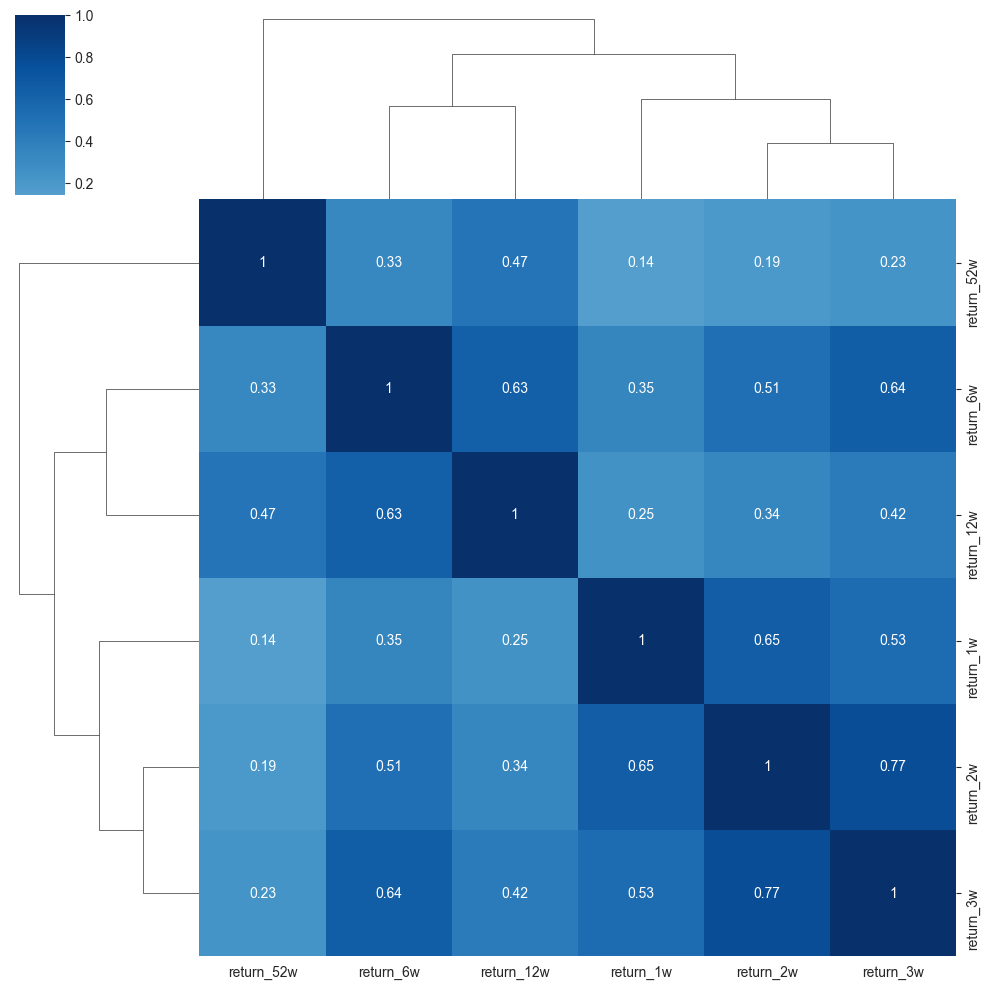

In [63]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr("spearman"), annot=True, center=0, cmap="Blues");

We are left with 1,670 tickers.

In [64]:
data.index.get_level_values("ticker").nunique()

9

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 8, Time Series Models]([](../../08_time_series_models)).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [65]:
factors = ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]
factor_data = web.DataReader(
    "F-F_Research_Data_5_Factors_2x3", "famafrench", start="2000"
)[0].drop("RF", axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample("M").last().ffill().div(100)

factor_data.index.name = "date"
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2000-01-31 to 2024-12-31
Freq: ME
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  300 non-null    float64
 1   SMB     300 non-null    float64
 2   HML     300 non-null    float64
 3   RMW     300 non-null    float64
 4   CMA     300 non-null    float64
dtypes: float64(5)
memory usage: 14.1 KB


In [66]:
factor_data.tail(20)

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2023-05-31,0.0035,-0.0038,-0.0774,-0.0182,-0.0720
2023-06-30,0.0647,0.0136,-0.0020,0.0227,-0.0162
2023-07-31,0.0321,0.0284,0.0411,-0.0057,0.0062
2023-08-31,-0.0239,-0.0368,-0.0108,0.0342,-0.0237
2023-09-30,-0.0524,-0.0179,0.0145,0.0185,-0.0084
2023-10-31,-0.0318,-0.0405,0.0019,0.0247,-0.0067
2023-11-30,0.0883,-0.0011,0.0166,-0.0381,-0.0099
2023-12-31,0.0487,0.0733,0.0492,-0.0304,0.0130
2024-01-31,0.0070,-0.0568,-0.0247,0.0066,-0.0102


### importante metemos el retorno sin adaptar para la regresión

In [67]:
data2["return_1w"].name

'return_1w'

In [68]:
factor_data = factor_data.join(return_1w_real).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2700 entries, ('XLB', Timestamp('2000-01-31 00:00:00')) to ('XLY', Timestamp('2024-12-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mkt-RF     2700 non-null   float64
 1   SMB        2700 non-null   float64
 2   HML        2700 non-null   float64
 3   RMW        2700 non-null   float64
 4   CMA        2700 non-null   float64
 5   return_1w  2700 non-null   float64
dtypes: float64(6)
memory usage: 145.4+ KB


In [69]:
T = 24  # 2 years
betas = factor_data.groupby(level="ticker", group_keys=False).apply(
    lambda x: RollingOLS(
        endog=x.return_1w,
        exog=sm.add_constant(x.drop("return_1w", axis=1)),
        window=min(T, x.shape[0] - 1),
    )
    .fit(params_only=True)
    .params
    # .drop('const', axis=1)
)

In [70]:
betas.describe().join(betas.sum(1).describe().to_frame("total"))

,const,Mkt-RF,SMB,HML,RMW,CMA,total
count,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2700.000000
mean,0.001085,0.981469,-0.067735,0.063667,0.109315,0.094533,1.091688
std,0.006559,0.296199,0.369353,0.600891,0.499273,0.734260,0.946890
min,-0.032293,-0.148207,-1.218264,-1.519237,-1.460530,-3.456075,-2.331985
25%,-0.002199,0.801075,-0.302980,-0.317008,-0.216581,-0.304907,0.402824
50%,0.001160,1.016004,-0.054935,-0.026396,0.166371,0.136534,1.074295
75%,0.004714,1.158402,0.134429,0.294810,0.380917,0.532075,1.700193
max,0.031571,2.298497,1.729157,3.469129,3.065329,3.118126,5.781477


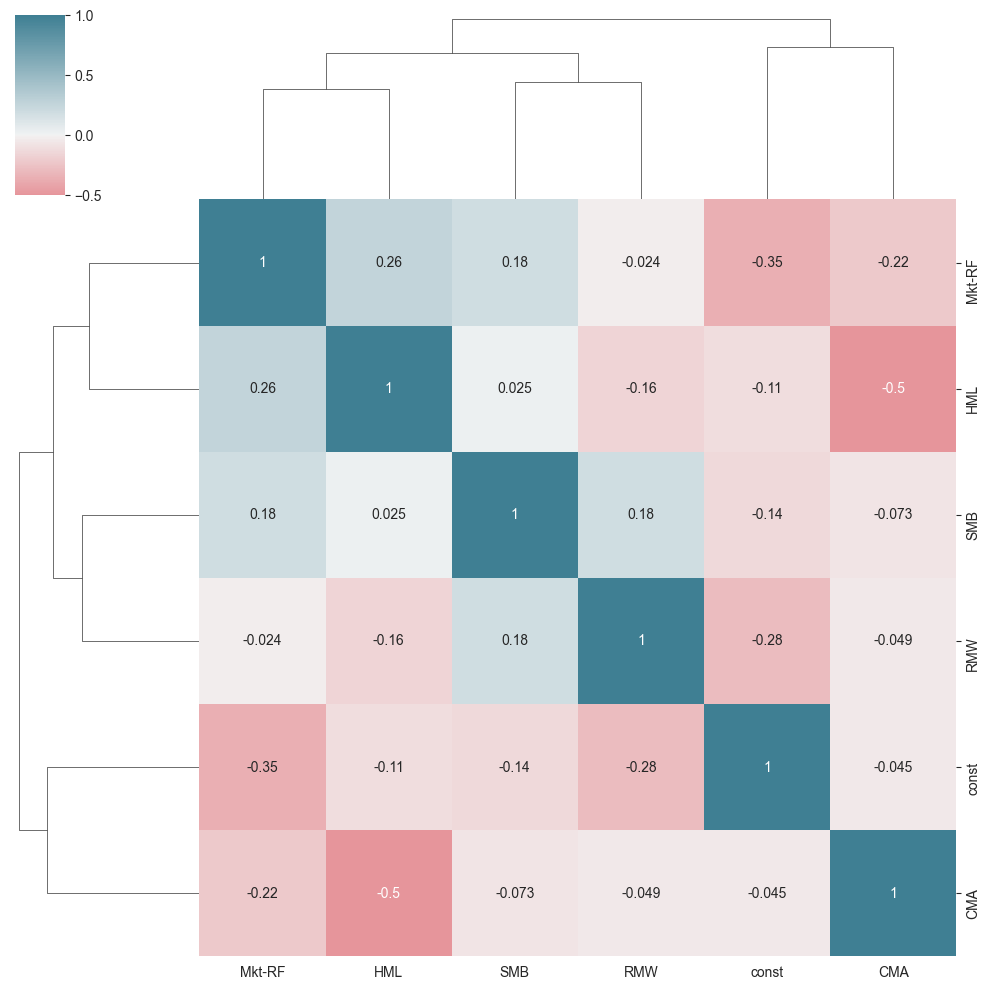

In [71]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [72]:
betas.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2700 entries, ('XLB', Timestamp('2000-01-31 00:00:00')) to ('XLY', Timestamp('2024-12-31 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   const   2493 non-null   float64
 1   Mkt-RF  2493 non-null   float64
 2   SMB     2493 non-null   float64
 3   HML     2493 non-null   float64
 4   RMW     2493 non-null   float64
 5   CMA     2493 non-null   float64
dtypes: float64(6)
memory usage: 145.4+ KB


In [73]:
betas.tail(20)

const    Mkt-RF       SMB       HML       RMW       CMA
ticker date                                                                  
XLY    2023-05-31  0.006017  1.173046 -0.063954  0.145495 -0.170514 -0.741721
       2023-06-30  0.007618  1.198337 -0.015125  0.150826 -0.144352 -0.759294
       2023-07-31  0.006623  1.186293 -0.066371  0.124519 -0.121575 -0.748224
       2023-08-31  0.008272  1.210683 -0.099265  0.157794 -0.174779 -0.786210
       2023-09-30  0.006252  1.227852 -0.086743  0.098176 -0.125845 -0.735068
       2023-10-31  0.004294  1.199020  0.062649  0.021367 -0.097306 -0.630286
       2023-11-30  0.002858  1.203341  0.000570  0.078236 -0.282844 -0.672379
       2023-12-31  0.002634  1.201713 -0.013435  0.079232 -0.285623 -0.677276
       2024-01-31 -0.000510  1.190936  0.340042 -0.137726 -0.097732 -0.538000
       2024-02-29 -0.000145  1.191160  0.343856 -0.144228 -0.108272 -0.527718
       2024-03-31 -0.002764  1.160642  0.389774 -0.064765 -0.018242 -0.679698
       2024-04-30 -0.004326  1.211391  0.307133 -0.048231 -0.095001 -0.773329
       2024-05-31 -0.005312  1.191913  0.203950 -0.032133 -0.277252 -0.684762
       2024-06-30 -0.002353  1.097375  0.409638 -0.190594 -0.118145 -0.663483
       2024-07-31 -0.002525  1.070863  0.379777 -0.213946 -0.170891 -0.548002
       2024-08-31 -0.001431  1.060854  0.383838 -0.236990 -0.222010 -0.501286
       2024-09-30 -0.000137  1.105558  0.445743 -0.395281 -0.207874 -0.343426
       2024-10-31  0.000477  1.166911  0.449705 -0.380805 -0.158161 -0.231947
       2024-11-30  0.001317  1.195068  0.484008 -0.402127 -0.141664 -0.208362
       2024-12-31  0.010474  1.018408  0.610982 -0.657216 -0.222063  0.171155

In [74]:
betas.loc["XLK", "2002"].head(10)

,const,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,
2002-01-31,0.018763,1.164545,-0.004368,-0.377221,0.084388,-1.179314
2002-02-28,0.015282,1.071558,-0.035136,-0.152629,0.066681,-1.563332
2002-03-31,0.016602,1.121516,-0.082615,-0.110741,0.143605,-1.683478
2002-04-30,0.012016,1.163256,0.063025,-0.107111,0.200036,-1.697778
2002-05-31,0.018138,1.055517,-0.045400,-0.021426,0.125870,-1.886309
2002-06-30,0.017239,1.105132,-0.043606,0.005488,0.101734,-1.854969
2002-07-31,0.011807,1.217230,0.071598,0.011322,0.131765,-1.717761
2002-08-31,0.005042,1.179937,0.173255,-0.088526,0.204370,-1.637457
2002-09-30,0.006475,1.384397,0.041860,-0.286308,0.034961,-0.969524


In [75]:
data = data.join(betas.groupby(level="ticker").shift(1))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11934 entries, ('XLB', Timestamp('1999-12-26 00:00:00')) to ('XLY', Timestamp('2025-05-18 00:00:00'))
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1w   11466 non-null  float64
 1   return_2w   11466 non-null  float64
 2   return_3w   11466 non-null  float64
 3   return_6w   11466 non-null  float64
 4   return_12w  11466 non-null  float64
 5   return_52w  11466 non-null  float64
 6   const       351 non-null    float64
 7   Mkt-RF      351 non-null    float64
 8   SMB         351 non-null    float64
 9   HML         351 non-null    float64
 10  RMW         351 non-null    float64
 11  CMA         351 non-null    float64
dtypes: float64(12)
memory usage: 1.4+ MB


In [76]:
data["const"].head(30)

ticker  date      
XLB     1999-12-26   NaN
        2000-01-02   NaN
        2000-01-09   NaN
        2000-01-16   NaN
        2000-01-23   NaN
        2000-01-30   NaN
        2000-02-06   NaN
        2000-02-13   NaN
        2000-02-20   NaN
        2000-02-27   NaN
        2000-03-05   NaN
        2000-03-12   NaN
        2000-03-19   NaN
        2000-03-26   NaN
        2000-04-02   NaN
        2000-04-09   NaN
        2000-04-16   NaN
        2000-04-23   NaN
        2000-04-30   NaN
        2000-05-07   NaN
        2000-05-14   NaN
        2000-05-21   NaN
        2000-05-28   NaN
        2000-06-04   NaN
        2000-06-11   NaN
        2000-06-18   NaN
        2000-06-25   NaN
        2000-07-02   NaN
        2000-07-09   NaN
        2000-07-16   NaN
Name: const, dtype: float64

### Impute mean for missing factor betas

In [77]:
factors = ["const", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]

In [78]:
# Ensure the result has the correct index structure
data[factors] = (
    data.groupby("ticker")[factors]
    .apply(lambda x: x.ffill())
    .reset_index(level=0, drop=True)
)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11934 entries, ('XLB', Timestamp('1999-12-26 00:00:00')) to ('XLY', Timestamp('2025-05-18 00:00:00'))
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1w   11466 non-null  float64
 1   return_2w   11466 non-null  float64
 2   return_3w   11466 non-null  float64
 3   return_6w   11466 non-null  float64
 4   return_12w  11466 non-null  float64
 5   return_52w  11466 non-null  float64
 6   const       10872 non-null  float64
 7   Mkt-RF      10872 non-null  float64
 8   SMB         10872 non-null  float64
 9   HML         10872 non-null  float64
 10  RMW         10872 non-null  float64
 11  CMA         10872 non-null  float64
dtypes: float64(12)
memory usage: 1.4+ MB


In [79]:
# incorporamos los cambios en los datos de betas
for columna in factors:
    data[columna + "_diff"] = data[columna].diff().replace(0, np.nan).ffill()

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent weekly return, as well as for the difference between 3 and 12 week returns as follows:

In [80]:
for lag in [2, 3, 6, 12, 52]:
    data[f"momentum_{lag}"] = data[f"return_{lag}w"].sub(data.return_1w)
data[f"momentum_3_12"] = data[f"return_12w"].sub(data.return_3w)

## Date Indicators

In [81]:
dates = data.index.get_level_values("date")
# data['year'] = dates.year
data["month"] = dates.month

In [82]:
print(dates)

DatetimeIndex(['1999-12-26', '2000-01-02', '2000-01-09', '2000-01-16',
               '2000-01-23', '2000-01-30', '2000-02-06', '2000-02-13',
               '2000-02-20', '2000-02-27',
               ...
               '2025-03-16', '2025-03-23', '2025-03-30', '2025-04-06',
               '2025-04-13', '2025-04-20', '2025-04-27', '2025-05-04',
               '2025-05-11', '2025-05-18'],
              dtype='datetime64[ns]', name='date', length=11934, freq=None)


## Sector

In [83]:
data.tail()

return_1w  return_2w  return_3w  return_6w  return_12w  \
ticker date                                                                 
XLY    2025-04-20  -0.795166   0.347179  -1.166644  -1.322193   -2.166428   
       2025-04-27   2.333966   1.020322   1.543260   0.095384   -1.526403   
       2025-05-04   0.664376   2.085759   1.161500   0.296682   -1.033874   
       2025-05-11   0.166384   0.580557   1.692732   0.352185   -1.031115   
       2025-05-18   2.578281   1.893782   1.836191   2.205808   -0.005047   

                   return_52w     const    Mkt-RF      SMB       HML  ...  \
ticker date                                                           ...   
XLY    2025-04-20    1.164442 -0.005312  1.191913  0.20395 -0.032133  ...   
       2025-04-27    1.491122 -0.005312  1.191913  0.20395 -0.032133  ...   
       2025-05-04    1.579925 -0.005312  1.191913  0.20395 -0.032133  ...   
       2025-05-11    1.622471 -0.005312  1.191913  0.20395 -0.032133  ...   
       2025-05-18    2.443488 -0.005312  1.191913  0.20395 -0.032133  ...   

                   HML_diff  RMW_diff  CMA_diff  momentum_2  momentum_3  \
ticker date                                                               
XLY    2025-04-20  0.112095  -0.16898 -0.157044    1.142345   -0.371479   
       2025-04-27  0.112095  -0.16898 -0.157044   -1.313644   -0.790706   
       2025-05-04  0.112095  -0.16898 -0.157044    1.421383    0.497124   
       2025-05-11  0.112095  -0.16898 -0.157044    0.414173    1.526348   
       2025-05-18  0.112095  -0.16898 -0.157044   -0.684499   -0.742090   

                   momentum_6  momentum_12  momentum_52  momentum_3_12  month  
ticker date                                                                    
XLY    2025-04-20   -0.527027    -1.371262     1.959607      -0.999784      4  
       2025-04-27   -2.238582    -3.860369    -0.842845      -3.069663      4  
       2025-05-04   -0.367694    -1.698251     0.915549      -2.195374      5  
       2025-05-11    0.185800    -1.197500     1.456087      -2.723847      5  
       2025-05-18   -0.372473    -2.583328    -0.134793      -1.841238      5  

[5 rows x 25 columns]

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11934 entries, ('XLB', Timestamp('1999-12-26 00:00:00')) to ('XLY', Timestamp('2025-05-18 00:00:00'))
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1w      11466 non-null  float64
 1   return_2w      11466 non-null  float64
 2   return_3w      11466 non-null  float64
 3   return_6w      11466 non-null  float64
 4   return_12w     11466 non-null  float64
 5   return_52w     11466 non-null  float64
 6   const          10872 non-null  float64
 7   Mkt-RF         10872 non-null  float64
 8   SMB            10872 non-null  float64
 9   HML            10872 non-null  float64
 10  RMW            10872 non-null  float64
 11  CMA            10872 non-null  float64
 12  const_diff     11803 non-null  float64
 13  Mkt-RF_diff    11803 non-null  float64
 14  SMB_diff       11803 non-null  float64
 15  HML_diff       11803 non-null  float64
 16  RMW_diff       118

In [85]:
data.index

MultiIndex([('XLB', '1999-12-26'),
            ('XLB', '2000-01-02'),
            ('XLB', '2000-01-09'),
            ('XLB', '2000-01-16'),
            ('XLB', '2000-01-23'),
            ('XLB', '2000-01-30'),
            ('XLB', '2000-02-06'),
            ('XLB', '2000-02-13'),
            ('XLB', '2000-02-20'),
            ('XLB', '2000-02-27'),
            ...
            ('XLY', '2025-03-16'),
            ('XLY', '2025-03-23'),
            ('XLY', '2025-03-30'),
            ('XLY', '2025-04-06'),
            ('XLY', '2025-04-13'),
            ('XLY', '2025-04-20'),
            ('XLY', '2025-04-27'),
            ('XLY', '2025-05-04'),
            ('XLY', '2025-05-11'),
            ('XLY', '2025-05-18')],
           names=['ticker', 'date'], length=11934)

In [86]:
# Crear una Serie con el índice del DataFrame y los valores del nivel 'ticker'
ticker_series = pd.Series(data.index.get_level_values("ticker"), index=data.index)

# Usar esta Serie para llenar los valores NA
data["sector"] = ticker_series

In [87]:
data["sector"]

ticker  date      
XLB     1999-12-26    XLB
        2000-01-02    XLB
        2000-01-09    XLB
        2000-01-16    XLB
        2000-01-23    XLB
                     ... 
XLY     2025-04-20    XLY
        2025-04-27    XLY
        2025-05-04    XLY
        2025-05-11    XLY
        2025-05-18    XLY
Name: sector, Length: 11934, dtype: object

In [88]:
data["sector"].unique()

array(['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY'],
      dtype=object)

In [89]:
data[data["sector"].isna()].index.get_level_values(0).unique()

Index([], dtype='object', name='ticker')

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11934 entries, ('XLB', Timestamp('1999-12-26 00:00:00')) to ('XLY', Timestamp('2025-05-18 00:00:00'))
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1w      11466 non-null  float64
 1   return_2w      11466 non-null  float64
 2   return_3w      11466 non-null  float64
 3   return_6w      11466 non-null  float64
 4   return_12w     11466 non-null  float64
 5   return_52w     11466 non-null  float64
 6   const          10872 non-null  float64
 7   Mkt-RF         10872 non-null  float64
 8   SMB            10872 non-null  float64
 9   HML            10872 non-null  float64
 10  RMW            10872 non-null  float64
 11  CMA            10872 non-null  float64
 12  const_diff     11803 non-null  float64
 13  Mkt-RF_diff    11803 non-null  float64
 14  SMB_diff       11803 non-null  float64
 15  HML_diff       11803 non-null  float64
 16  RMW_diff       118

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [91]:
for t in range(1, 7):
    data[f"return_1w_t-{t}"] = data.groupby(level="ticker").return_1w.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11934 entries, ('XLB', Timestamp('1999-12-26 00:00:00')) to ('XLY', Timestamp('2025-05-18 00:00:00'))
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1w      11466 non-null  float64
 1   return_2w      11466 non-null  float64
 2   return_3w      11466 non-null  float64
 3   return_6w      11466 non-null  float64
 4   return_12w     11466 non-null  float64
 5   return_52w     11466 non-null  float64
 6   const          10872 non-null  float64
 7   Mkt-RF         10872 non-null  float64
 8   SMB            10872 non-null  float64
 9   HML            10872 non-null  float64
 10  RMW            10872 non-null  float64
 11  CMA            10872 non-null  float64
 12  const_diff     11803 non-null  float64
 13  Mkt-RF_diff    11803 non-null  float64
 14  SMB_diff       11803 non-null  float64
 15  HML_diff       11803 non-null  float64
 16  RMW_diff       118

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [92]:
for t in [1, 2, 3, 6, 12]:
    data[f"target_{t}w"] = data.groupby(level="ticker")[f"return_{t}w"].shift(-t)

In [93]:
cols = [
    "target_1w",
    "target_2w",
    "target_3w",
    "return_1w",
    "return_2w",
    "return_3w",
    "return_1w_t-1",
    "return_1w_t-2",
    "return_1w_t-3",
]

data[cols].dropna().sort_index().head(10)

target_1w  target_2w  target_3w  return_1w  return_2w  \
ticker date                                                                
XLB    2001-01-14  -0.164124   0.210401   0.855526  -2.069498  -1.456077   
       2001-01-21   0.486567   1.202278   0.755499  -0.164124  -1.502735   
       2001-01-28   1.266643   0.590155   0.509243   0.486567   0.210401   
       2001-02-04  -0.368354  -0.241326  -0.481278   1.266643   1.202278   
       2001-02-11   0.026693  -0.322995   0.790704  -0.368354   0.590155   
       2001-02-18  -0.493594   0.927134   1.420396   0.026693  -0.241326   
       2001-02-25   1.898487   2.016010   0.072790  -0.493594  -0.322995   
       2001-03-04   1.088240  -1.114189  -1.354882   1.898487   0.927134   
       2001-03-11  -2.206551  -2.177617  -1.784738   1.088240   2.016010   
       2001-03-18  -0.654737  -0.249957   0.171947  -2.206551  -1.114189   

                   return_3w  return_1w_t-1  return_1w_t-2  return_1w_t-3  
ticker date                                                                
XLB    2001-01-14  -1.131606      -0.057901       0.076192       2.198883  
       2001-01-21  -1.257102      -2.069498      -0.057901       0.076192  
       2001-01-28  -0.967886      -0.164124      -2.069498      -0.057901  
       2001-02-04   0.855526       0.486567      -0.164124      -2.069498  
       2001-02-11   0.755499       1.266643       0.486567      -0.164124  
       2001-02-18   0.509243      -0.368354       1.266643       0.486567  
       2001-02-25  -0.481278       0.026693      -0.368354       1.266643  
       2001-03-04   0.790704      -0.493594       0.026693      -0.368354  
       2001-03-11   1.420396       1.898487      -0.493594       0.026693  
       2001-03-18   0.072790       1.088240       1.898487      -0.493594

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11934 entries, ('XLB', Timestamp('1999-12-26 00:00:00')) to ('XLY', Timestamp('2025-05-18 00:00:00'))
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1w      11466 non-null  float64
 1   return_2w      11466 non-null  float64
 2   return_3w      11466 non-null  float64
 3   return_6w      11466 non-null  float64
 4   return_12w     11466 non-null  float64
 5   return_52w     11466 non-null  float64
 6   const          10872 non-null  float64
 7   Mkt-RF         10872 non-null  float64
 8   SMB            10872 non-null  float64
 9   HML            10872 non-null  float64
 10  RMW            10872 non-null  float64
 11  CMA            10872 non-null  float64
 12  const_diff     11803 non-null  float64
 13  Mkt-RF_diff    11803 non-null  float64
 14  SMB_diff       11803 non-null  float64
 15  HML_diff       11803 non-null  float64
 16  RMW_diff       118

## The Data: Recessions & Leading Indicators

We will use a small and simple dataset so we can focus on the workflow. We use the Federal Reserve’s Economic Data (FRED) service (see Chapter 2) to download the US recession dates as defined by the National Bureau of Economic Research. We also source four variables that are commonly used to predict the onset of a recession (Kelley 2019) and available via FRED, namely:

The long-term spread of the treasury yield curve, defined as the difference between the ten-year and the three-week Treasury yield.
The University of Michigan’s consumer sentiment indicator
The National Financial Conditions Index (NFCI), and
The NFCI nonfinancial leverage subindex.

### Download from FRED

In [95]:
indicators = [
    "JHDUSRGDPBR",
    "T10Y3M",
    "BAMLC0A0CM",
    "BAMLH0A0HYM2",
    "BAMLHE00EHYIOAS",
    "UMCSENT",
    "UNRATE",
    "GDPC1",
    "DCOILWTICO",
    "CORESTICKM159SFRBATL",
    "USSLIND",
    "VIXCLS",
    "OVXCLS",
    "ICSA",
    "MARTSMPCSM44000USS",
    "RSXFS",
    "TREAST",
    "DGS1",
]
var_names = [
    "recession",
    "yield_curve",
    "corp_oas",
    "hy_oas",
    "eu_hy_oas",
    "sentiment",
    "empleo",
    "real_gdp",
    "oil",
    "inflacion",
    "leading",
    "vix",
    "vixoil",
    "weekjobclaims",
    "retail_sales_percent",
    "retail_sales",
    "us_asset_balance",
    "1y_yield",
]

In [96]:
features = var_names[1:]
label = var_names[0]

In [97]:
var_display = [
    "Recession",
    "Yield Curve",
    "corp_oas",
    "hy_oas",
    "eu_hy_oas",
    "Sentiment",
    "empleo",
    "real_gdp",
    "oil",
    "inflacion",
    "leading",
    "vix",
    "vixoil",
    "weekjobclaims",
    "retail_sales_percent",
    "retail_sales",
    "us_asset_balance",
    "1y_yield",
]
col_dict = dict(zip(var_names, var_display))

In [98]:
data_fred = (
    web.DataReader(indicators, "fred", 1980, END + 1).resample("W").last().ffill()
)
data_fred.columns = var_names

In [99]:
data_fred.tail()

,recession,yield_curve,corp_oas,hy_oas,eu_hy_oas,sentiment,empleo,real_gdp,oil,inflacion,leading,vix,vixoil,weekjobclaims,retail_sales_percent,retail_sales,us_asset_balance,1y_yield
DATE,,,,,,,,,,,,,,,,,,
2025-04-20,0.0,0.00,1.11,4.02,3.87,57.0,4.2,23526.085,65.07,3.17669,1.72,29.65,41.27,223000.0,-0.1,625038.0,4217259.0,3.99
2025-04-27,0.0,-0.03,1.04,3.67,3.54,57.0,4.2,23526.085,63.85,3.17669,1.72,24.84,43.53,241000.0,-0.1,625038.0,4217694.0,3.95
2025-05-04,0.0,0.00,1.06,3.60,3.65,57.0,4.2,23526.085,59.67,3.17669,1.72,22.68,50.59,229000.0,-0.1,625038.0,4215813.0,4.00
2025-05-11,0.0,0.03,1.02,3.53,3.49,57.0,4.2,23526.085,62.37,3.17669,1.72,21.90,39.82,229000.0,-0.1,625038.0,4216103.0,4.05
2025-05-18,0.0,0.06,0.94,3.20,3.28,57.0,4.2,23526.085,63.32,3.17669,1.72,17.83,37.40,229000.0,-0.1,625038.0,4216393.0,4.10


We standardize the features so all have mean 0 standard deviation of 1:

In [100]:
data_fred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2368 entries, 1980-01-06 to 2025-05-18
Freq: W-SUN
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recession             2368 non-null   float64
 1   yield_curve           2263 non-null   float64
 2   corp_oas              1481 non-null   float64
 3   hy_oas                1481 non-null   float64
 4   eu_hy_oas             1429 non-null   float64
 5   sentiment             2368 non-null   float64
 6   empleo                2368 non-null   float64
 7   real_gdp              2368 non-null   float64
 8   oil                   2055 non-null   float64
 9   inflacion             2368 non-null   float64
 10  leading               2264 non-null   float64
 11  vix                   1846 non-null   float64
 12  vixoil                941 non-null    float64
 13  weekjobclaims         2368 non-null   float64
 14  retail_sales_percent  1738 non-null   floa

In [101]:
data_fred.index.name = "date"

In [102]:
data_fred.tail()

,recession,yield_curve,corp_oas,hy_oas,eu_hy_oas,sentiment,empleo,real_gdp,oil,inflacion,leading,vix,vixoil,weekjobclaims,retail_sales_percent,retail_sales,us_asset_balance,1y_yield
date,,,,,,,,,,,,,,,,,,
2025-04-20,0.0,0.00,1.11,4.02,3.87,57.0,4.2,23526.085,65.07,3.17669,1.72,29.65,41.27,223000.0,-0.1,625038.0,4217259.0,3.99
2025-04-27,0.0,-0.03,1.04,3.67,3.54,57.0,4.2,23526.085,63.85,3.17669,1.72,24.84,43.53,241000.0,-0.1,625038.0,4217694.0,3.95
2025-05-04,0.0,0.00,1.06,3.60,3.65,57.0,4.2,23526.085,59.67,3.17669,1.72,22.68,50.59,229000.0,-0.1,625038.0,4215813.0,4.00
2025-05-11,0.0,0.03,1.02,3.53,3.49,57.0,4.2,23526.085,62.37,3.17669,1.72,21.90,39.82,229000.0,-0.1,625038.0,4216103.0,4.05
2025-05-18,0.0,0.06,0.94,3.20,3.28,57.0,4.2,23526.085,63.32,3.17669,1.72,17.83,37.40,229000.0,-0.1,625038.0,4216393.0,4.10


In [103]:
data_fred.head()

,recession,yield_curve,corp_oas,hy_oas,eu_hy_oas,sentiment,empleo,real_gdp,oil,inflacion,leading,vix,vixoil,weekjobclaims,retail_sales_percent,retail_sales,us_asset_balance,1y_yield
date,,,,,,,,,,,,,,,,,,
1980-01-06,1.0,NaN,NaN,NaN,NaN,67.0,6.3,7341.557,NaN,13.469736,NaN,NaN,NaN,394000.0,NaN,NaN,NaN,12.25
1980-01-13,1.0,NaN,NaN,NaN,NaN,67.0,6.3,7341.557,NaN,13.469736,NaN,NaN,NaN,405000.0,NaN,NaN,NaN,11.94
1980-01-20,1.0,NaN,NaN,NaN,NaN,67.0,6.3,7341.557,NaN,13.469736,NaN,NaN,NaN,446000.0,NaN,NaN,NaN,12.05
1980-01-27,1.0,NaN,NaN,NaN,NaN,67.0,6.3,7341.557,NaN,13.469736,NaN,NaN,NaN,412000.0,NaN,NaN,NaN,12.24
1980-02-03,1.0,NaN,NaN,NaN,NaN,66.9,6.3,7341.557,NaN,13.599493,NaN,NaN,NaN,404000.0,NaN,NaN,NaN,12.62


In [104]:
# incorporamos los cambios en los datos
for columna in data_fred.columns:
    data_fred[columna + "_diff"] = data_fred[columna].diff().replace(0, np.nan).ffill()
    data_fred[columna + "_chg"] = (
        data_fred[columna].pct_change().replace(0, np.nan).ffill()
    )

In [105]:
# eliminamos algunas variables que tienen mucha dependencia del nivel historico
data_fred = data_fred.drop(["empleo", "us_asset_balance"], axis=1)

In [106]:
# para hacer bbfill sólo hasta que encuentre un primer valor
for columna in data_fred.columns:
    # Verificar si la columna tiene NaN al inicio
    if data_fred[columna].isna().iloc[0]:
        # Obtiene el primer valor no NaN de la columna
        primer_valor = data_fred[columna].dropna().iloc[0]
        # Rellena los NaN iniciales con el primer valor no NaN
        data_fred[columna][: data_fred[columna].first_valid_index()] = primer_valor

In [107]:
data_fred.head(5)

,recession,yield_curve,corp_oas,hy_oas,eu_hy_oas,sentiment,real_gdp,oil,inflacion,leading,...,weekjobclaims_diff,weekjobclaims_chg,retail_sales_percent_diff,retail_sales_percent_chg,retail_sales_diff,retail_sales_chg,us_asset_balance_diff,us_asset_balance_chg,1y_yield_diff,1y_yield_chg
date,,,,,,,,,,,,,,,,,,,,,
1980-01-06,1.0,2.5,0.61,3.09,6.32,67.0,7341.557,26.0,13.469736,-0.89,...,11000.0,0.027919,-0.4,-4.0,165.0,0.001159,5.0,0.000008,-0.31,-0.025306
1980-01-13,1.0,2.5,0.61,3.09,6.32,67.0,7341.557,26.0,13.469736,-0.89,...,11000.0,0.027919,-0.4,-4.0,165.0,0.001159,5.0,0.000008,-0.31,-0.025306
1980-01-20,1.0,2.5,0.61,3.09,6.32,67.0,7341.557,26.0,13.469736,-0.89,...,41000.0,0.101235,-0.4,-4.0,165.0,0.001159,5.0,0.000008,0.11,0.009213
1980-01-27,1.0,2.5,0.61,3.09,6.32,67.0,7341.557,26.0,13.469736,-0.89,...,-34000.0,-0.076233,-0.4,-4.0,165.0,0.001159,5.0,0.000008,0.19,0.015768
1980-02-03,1.0,2.5,0.61,3.09,6.32,66.9,7341.557,26.0,13.599493,-0.89,...,-8000.0,-0.019417,-0.4,-4.0,165.0,0.001159,5.0,0.000008,0.38,0.031046


In [108]:
# data_fred.index = data_fred.index.to_timestamp()
data_fred.index.name = "date"

In [109]:
data = data.join(data_fred)

# Data final shape
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11934 entries, ('XLB', Timestamp('1999-12-26 00:00:00')) to ('XLY', Timestamp('2025-05-18 00:00:00'))
Data columns (total 89 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   return_1w                  11466 non-null  float64
 1   return_2w                  11466 non-null  float64
 2   return_3w                  11466 non-null  float64
 3   return_6w                  11466 non-null  float64
 4   return_12w                 11466 non-null  float64
 5   return_52w                 11466 non-null  float64
 6   const                      10872 non-null  float64
 7   Mkt-RF                     10872 non-null  float64
 8   SMB                        10872 non-null  float64
 9   HML                        10872 non-null  float64
 10  RMW                        10872 non-null  float64
 11  CMA                        10872 non-null  float64
 12  const_diff                

## Store data

We will use the data again in several later chapters, starting in [Chapter 7 on Linear Models](../../07_linear_models/README.md).

In [110]:
with pd.HDFStore(DATA_STORE) as store:
    store.put("engineered_features", data.sort_index())
    store.put("data_raw", data2.sort_index())  # antes de normalizado de retornos
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/assets2.h5
/data_close                     frame        (shape->[59769,5]) 
/data_raw                       frame        (shape->[11934,6]) 
/engineered_features            frame        (shape->[11934,89])
